In [40]:
## Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

## Plotting 
import matplotlib.pyplot as plt 
import seaborn as sns
from figurefirst import mpl_functions

## 
import odor_stat_calculations as osc
import pandas as pd 
import os
import numpy as np

## scipy gaussian regressor 
import scipy
import scipy.stats as stats
from scipy.spatial.distance import cdist
from scipy.stats import kurtosis
from scipy.stats import ks_2samp
from sklearn.isotonic import IsotonicRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.formula.api as smf
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, Matern
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from concurrent.futures import ProcessPoolExecutor
from sklearn.linear_model import LogisticRegression, LinearRegression

## bayesian optimization 
from skopt import gp_minimize
from skopt.space import Real, Categorical
from sklearn.model_selection import cross_val_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import accuracy_score, classification_report
from mpl_toolkits.axes_grid1 import make_axes_locatable 

from joblib import load, dump

In [34]:
# Load the data
df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
df_train = df[:22000]
df_test = df[22000:]

# df = pd.read_hdf('/home/gorilla/An/data/Sprints/LowRes/WindyForSim.h5')
query = 'odor>=2'
df_train = df_train.query(query)
df_train.reset_index(inplace=True, drop=True) 


df_test = df_test.query(query)
df_test.reset_index(inplace=True, drop=True) 


In [35]:
def fit_exponential_distribution(far_data, threshold):
    non_saturated_data = far_data[far_data['odor'] < threshold]['odor']
    loc, scale = expon.fit(non_saturated_data)
    return loc, scale

loc, scale = fit_exponential_distribution(far_data, saturation_threshold)

# Function to generate values above a threshold
def generate_values_above_threshold(loc, scale, threshold, size):
    cdf_threshold = expon.cdf(threshold, loc=loc, scale=scale)
    uniform_values = np.random.uniform(cdf_threshold, 1, size)
    values_above_threshold = expon.ppf(uniform_values, loc=loc, scale=scale)
    return values_above_threshold

# Function to estimate and replace saturated values
def estimate_values_with_exponential_distribution(df, threshold, loc, scale):
    saturated_indices = df[df['odor'] >= threshold].index
    estimated_values = generate_values_above_threshold(loc, scale, threshold, len(saturated_indices))
    df.loc[saturated_indices, 'odor'] = estimated_values
    return df

# Copy the train data
df_extracted = df_train.copy()

# Set thresholds
far_distance_threshold = 10 
saturation_threshold = 10 

# Filter far data
far_data = df_extracted[df_extracted['distance_along_streakline'] > far_distance_threshold]

# Apply the correction to the training data
df_corrected = estimate_values_with_exponential_distribution(df_extracted.copy(), saturation_threshold, loc, scale)

# Prepare the features and target for GPR
X = df_corrected[['distance_along_streakline', 'nearest_from_streakline']].values
y = df_corrected['odor'].values.reshape(-1, 1)
y_transformed, lambda_ = boxcox(y.flatten() + 1)  # Add 1 to avoid log of zero

In [36]:
# Scale the features and target
use_scaler = True  
if use_scaler:
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
else:
    scaler = None
    X_scaled = X

target_scaler = StandardScaler()
y_scaled = target_scaler.fit_transform(y_transformed.reshape(-1, 1)).flatten()

# Define the kernel for the Gaussian Process Regressor
kernel = C(0.814**2, (1e-2, 1e2)) * (RBF(0.1, (1e-2, 1e1)) + Matern(length_scale=0.1, nu=0.5))
alpha = 0.263

# Train the GPR model
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3, alpha=alpha)
gp.fit(X_scaled, y_scaled)


trained_model = gp
trained_scaler = scaler
trained_target_scaler = target_scaler
print(gp.kernel_)
print("Spatial Model Training Done")


0.815**2 * RBF(length_scale=0.56) + Matern(length_scale=0.00257, nu=0.5)
Spatial Model Training Done


In [37]:
# Prepare the test data
new_test_df = df_test.copy()
new_test_df.reset_index(inplace=True, drop=True)

# Apply the correction to the test data
new_test_corrected = estimate_values_with_exponential_distribution(new_test_df.copy(), saturation_threshold, loc, scale)

# Prepare the test features
new_X_test = new_test_corrected[['distance_along_streakline', 'nearest_from_streakline']].values

if trained_scaler is not None:
    new_X_test_scaled = trained_scaler.transform(new_X_test)
else:
    new_X_test_scaled = new_X_test

# Make predictions with the trained GPR
new_y_pred_mean, new_y_pred_std = trained_model.predict(new_X_test_scaled, return_std=True)

# Inverse transform the predictions
new_y_pred_mean_transformed = trained_target_scaler.inverse_transform(new_y_pred_mean.reshape(-1, 1)).flatten()
new_y_pred_mean_original = scipy.special.inv_boxcox(new_y_pred_mean_transformed, lambda_) - 1  # Subtract 1 to reverse earlier addition


In [38]:

rng = np.random.default_rng()
sampled_predictions = rng.normal(loc=new_y_pred_mean_original, scale=new_y_pred_std)

new_test_df['sampled_predictions'] = sampled_predictions
new_test_df['corrected_odor'] = new_test_corrected['odor']

# Quantile Mapping to adjust predictions
def quantile_mapping(predictions, mean_pred, std_pred, mean_train, std_train):
    quantiles = norm.cdf(predictions, loc=mean_pred, scale=std_pred)
    adjusted_predictions = norm.ppf(quantiles, loc=mean_train, scale=std_train)
    return adjusted_predictions

# Fit normal distributions to the train data and predictions
mean_train, std_train = norm.fit(df_corrected['odor'])
mean_pred, std_pred = norm.fit(new_test_df['sampled_predictions'])

# Apply quantile mapping
adjusted_predictions = quantile_mapping(new_test_df['sampled_predictions'], mean_pred, std_pred, mean_train, std_train)
new_test_df['adjusted_y_predicted'] = adjusted_predictions

# Clip the adjusted predictions
min_val = df_test['odor'].min()
max_val = df_test['odor'].max()

adjusted_predictions_clipped = np.clip(new_test_df['adjusted_y_predicted'], min_val, max_val)
new_test_df['adjusted_y_predicted_clipped'] = adjusted_predictions_clipped


In [45]:
new_test_df.keys()

Index(['master_time', 'xsrc', 'ysrc', 'lat', 'lon', 'odor', 'trisonica_u',
       'trisonica_v', 'trisonica_pressure', 'trisonica_temperature',
       'gps_linear_x', 'gps_linear_y', 'gps_linear_z', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'imu_linear_acc_x',
       'imu_linear_acc_y', 'imu_linear_acc_z', 'U', 'V', 'D', 'S2', 'time',
       'corrected_u', 'corrected_v', 'distance_from_source', 'odorsim',
       'nearest_from_streakline', 'relative_parallel_comp',
       'relative_perpendicular_comp', 'sign_encounter', 'ysign', 'xsign',
       'distance_along_streakline', 'sampled_predictions', 'corrected_odor',
       'adjusted_y_predicted', 'adjusted_y_predicted_clipped',
       'whiff_probability'],
      dtype='object')

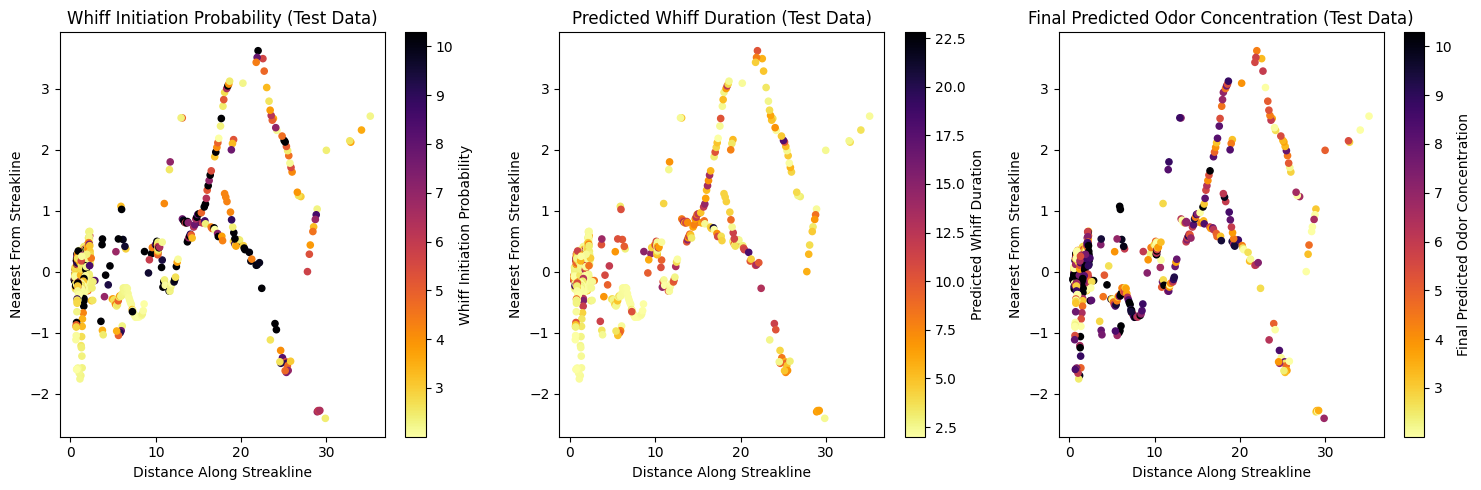

In [68]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(df_test['distance_along_streakline'], df_test['nearest_from_streakline'], c=df_test['odor'], cmap='inferno_r', s=20)
plt.colorbar(label='Whiff Initiation Probability')
plt.title('Whiff Initiation Probability (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['corrected_odor'], cmap='inferno_r', s=20)
plt.colorbar(label='Predicted Whiff Duration')
plt.title('Predicted Whiff Duration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['adjusted_y_predicted_clipped'], cmap='inferno_r', s=20)
plt.colorbar(label='Final Predicted Odor Concentration')
plt.title('Final Predicted Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.tight_layout()


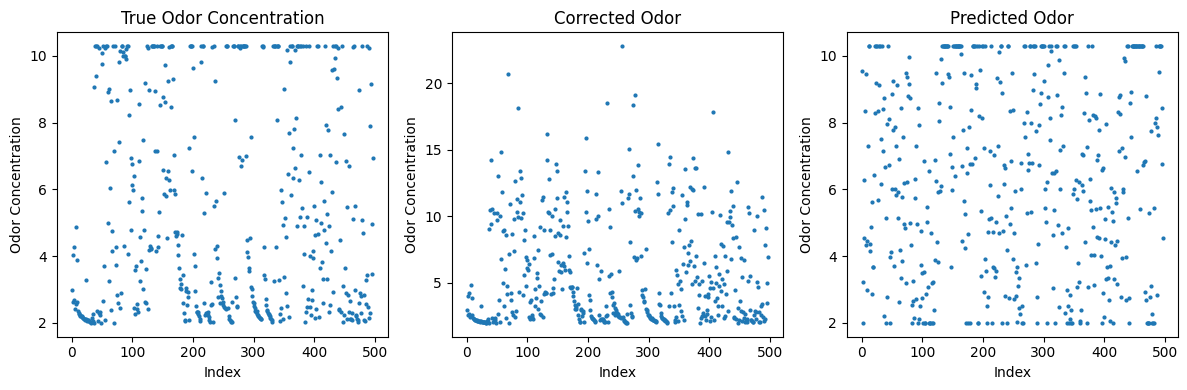

In [50]:
fig, ax = plt.subplots(1,3, figsize=(12, 4))  

ax[0].plot(df_test.index, df_test['odor'], 'o', markersize=2, label='True Odor')
ax[0].set_title('True Odor Concentration')
ax[0].set_xlabel('Index')
ax[0].set_ylabel('Odor Concentration')
# ax[0].legend()

ax[1].plot(new_test_df.index, new_test_df['corrected_odor'], 'o', markersize=2,label='Corrected Odor')
ax[1].set_title('Corrected Odor')
ax[1].set_xlabel('Index')
ax[1].set_ylabel('Odor Concentration')
# ax[1].legend()


# Plotting the predicted odor
ax[2].plot(new_test_df.index, new_test_df.adjusted_y_predicted_clipped, 'o', markersize=2, label='Predicted Odor')
ax[2].set_title('Predicted Odor')
ax[2].set_xlabel('Index')
ax[2].set_ylabel('Odor Concentration')
# ax[2].legend()

fig.tight_layout()

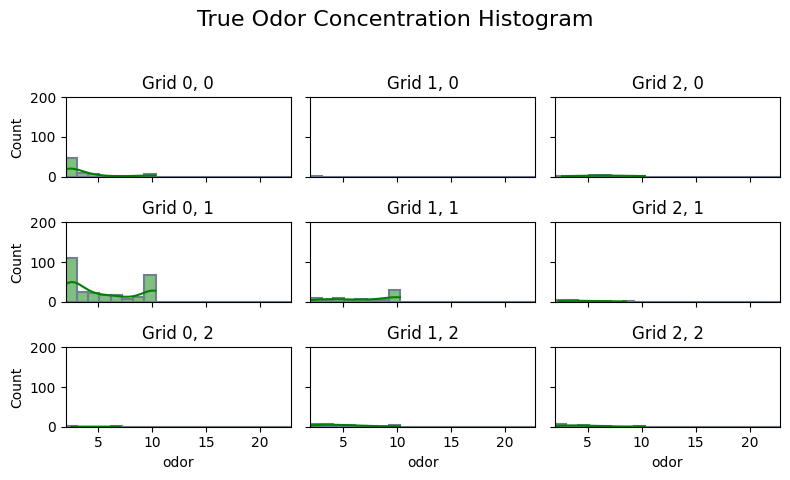

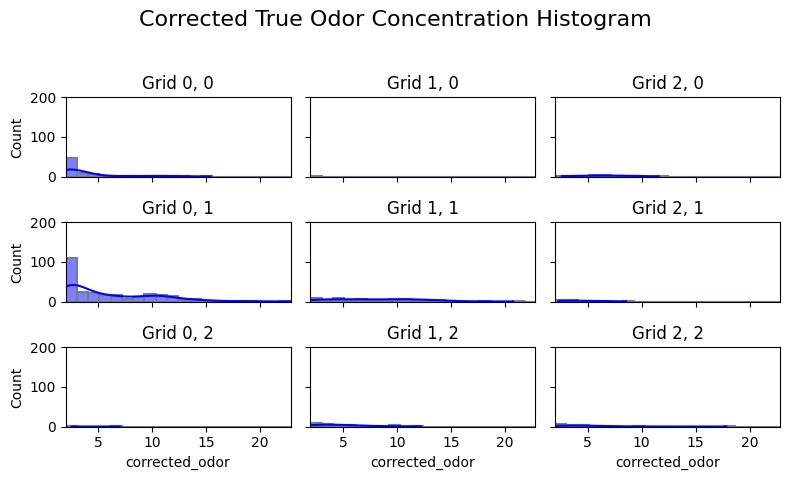

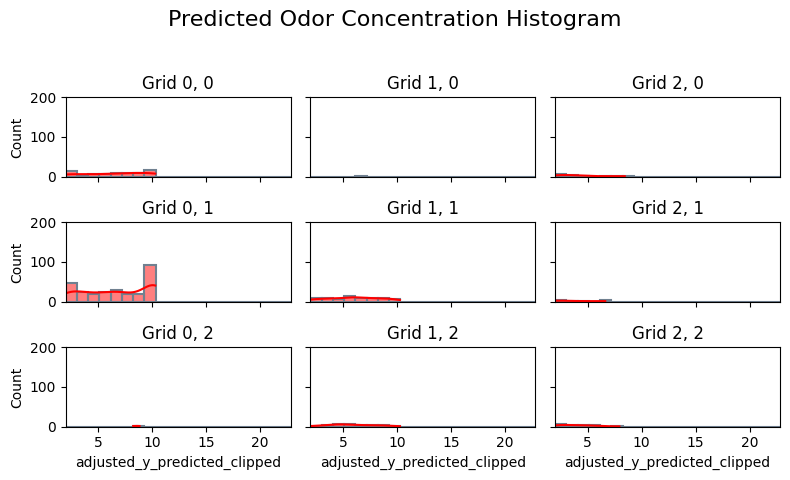

In [53]:
# Define the number of bins for the grid
n_bins_x = 3
n_bins_y = 3
n_bins_hist = 20

x_bin_edges = np.linspace(new_test_df['distance_along_streakline'].min(), new_test_df['distance_along_streakline'].max(), n_bins_x + 1)
y_bin_edges = np.linspace(new_test_df['nearest_from_streakline'].min(), new_test_df['nearest_from_streakline'].max(), n_bins_y + 1)

new_test_df['x_bin'] = pd.cut(new_test_df['distance_along_streakline'], bins=x_bin_edges, labels=False)
new_test_df['y_bin'] = pd.cut(new_test_df['nearest_from_streakline'], bins=y_bin_edges, labels=False)
# Determine global range for histogram bins
global_min = new_test_df[['odor', 'corrected_odor', 'adjusted_y_predicted_clipped']].min().min()
global_max = new_test_df[['odor', 'corrected_odor', 'adjusted_y_predicted_clipped']].max().max()
bin_edges = np.linspace(global_min, global_max, n_bins_hist + 1)

# Define specific x-axis limits
specific_x_min = global_min
specific_x_max = global_max
ylim=[0,200]
# Plot histograms for true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='green', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for corrected true odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['corrected_odor']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='blue', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Corrected True Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Plot histograms for predicted odor concentration
fig, axes = plt.subplots(n_bins_y, n_bins_x, figsize=(8, 5), sharex=True, sharey=True)
for i in range(n_bins_x):
    for j in range(n_bins_y):
        grid_data = new_test_df[(new_test_df['x_bin'] == i) & (new_test_df['y_bin'] == j)]['adjusted_y_predicted_clipped']
        ax = axes[j, i]  # Note the reversed order of j and i to match the grid layout
        if not grid_data.empty:
            sns.histplot(grid_data, bins=bin_edges, kde=True, ax=ax, color='red', edgecolor='slategray', linewidth=1.5)
            ax.set_xlim([specific_x_min, specific_x_max])
            ax.set_ylim(ylim)  # Adjusted to fit the actual data range
            ax.set_title(f'Grid {i}, {j}')
        else:
            ax.set_title(f'Grid {i}, {j} (empty)')
            ax.axis('off')

fig.suptitle('Predicted Odor Concentration Histogram', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


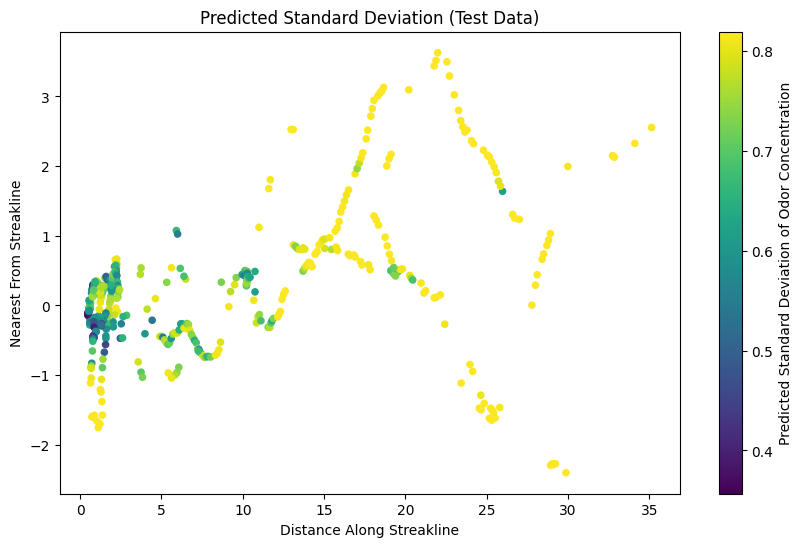

In [58]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(x=new_test_df['distance_along_streakline'], 
                      y=new_test_df['nearest_from_streakline'], 
                      c=new_y_pred_std, 
                      cmap="viridis", 
                      s=20)
plt.colorbar(scatter, label='Predicted Standard Deviation of Odor Concentration')
plt.title('Predicted Standard Deviation (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')
plt.show()


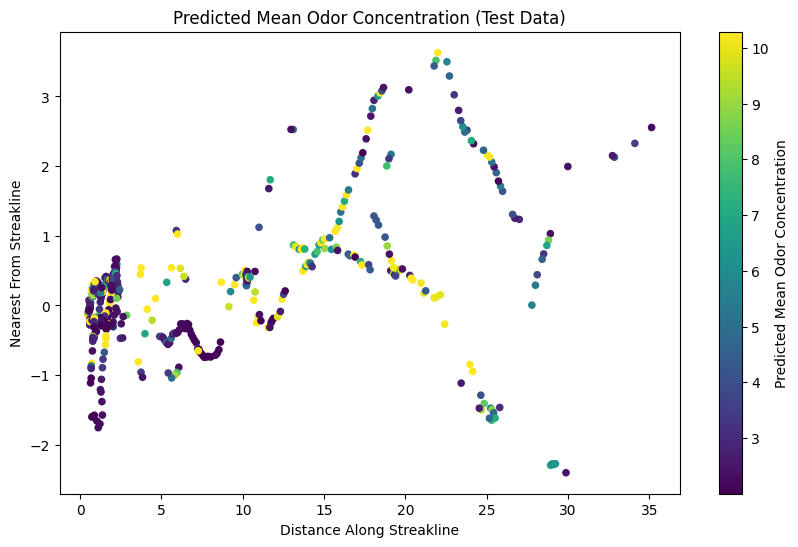

In [63]:
plt.figure(figsize=(10, 6))
plt.scatter(x=df_test['distance_along_streakline'], 
                y=df_test['nearest_from_streakline'], 
                c=df_test.odor, 
                cmap="viridis", 
                s=20)
plt.colorbar(label='Predicted Mean Odor Concentration')
plt.title('Predicted Mean Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')
plt.show()

In [44]:
# Temporal Predictions

# Whiff Initiation Prediction
# Label the training data for whiff initiation (1 if odor > threshold, 0 otherwise)
whiff_threshold = 5 # Define your whiff threshold
df_corrected['whiff_initiation'] = (df_corrected['odor'] > whiff_threshold).astype(int)

# Train logistic regression for whiff initiation
X_train_whiff = X_scaled  # Use the same features as for GPR
y_train_whiff = df_corrected['whiff_initiation']

logistic_model = LogisticRegression()
logistic_model.fit(X_train_whiff, y_train_whiff)

# Predict whiff initiation probabilities on the test data
whiff_probabilities = logistic_model.predict_proba(new_X_test_scaled)[:, 1]
new_test_df['whiff_probability'] = whiff_probabilities

# Whiff Duration Prediction
# Assuming you have a column 'whiff_duration' in your training data that represents the duration of each whiff
# You would need to calculate this if it's not already present

# Filter data for whiff occurrences
whiff_data = df_corrected[df_corrected['whiff_initiation'] == 1]
X_train_duration = whiff_data[['distance_along_streakline', 'nearest_from_streakline']].values
y_train_duration = whiff_data['whiff_duration'].values  # Assuming whiff duration is in the data

# Train a regression model for whiff duration
duration_model = LinearRegression()
duration_model.fit(X_train_duration, y_train_duration)

# Predict whiff duration on test data where whiff initiation is likely
predicted_duration = duration_model.predict(new_X_test_scaled[whiff_probabilities > 0.5])
new_test_df.loc[whiff_probabilities > 0.5, 'predicted_whiff_duration'] = predicted_duration

# Combine Spatial and Temporal Predictions
# Apply odor concentration predictions only where a whiff is predicted
new_test_df['final_predicted_concentration'] = 0  # Initialize with zeros

# Apply the concentration predictions where whiff initiation is likely
whiff_mask = new_test_df['whiff_probability'] > 0.5  # Adjust threshold as needed
new_test_df.loc[whiff_mask, 'final_predicted_concentration'] = new_test_df.loc[whiff_mask, 'sampled_predictions']


KeyError: 'whiff_duration'

Text(0, 0.5, 'Nearest From Streakline')

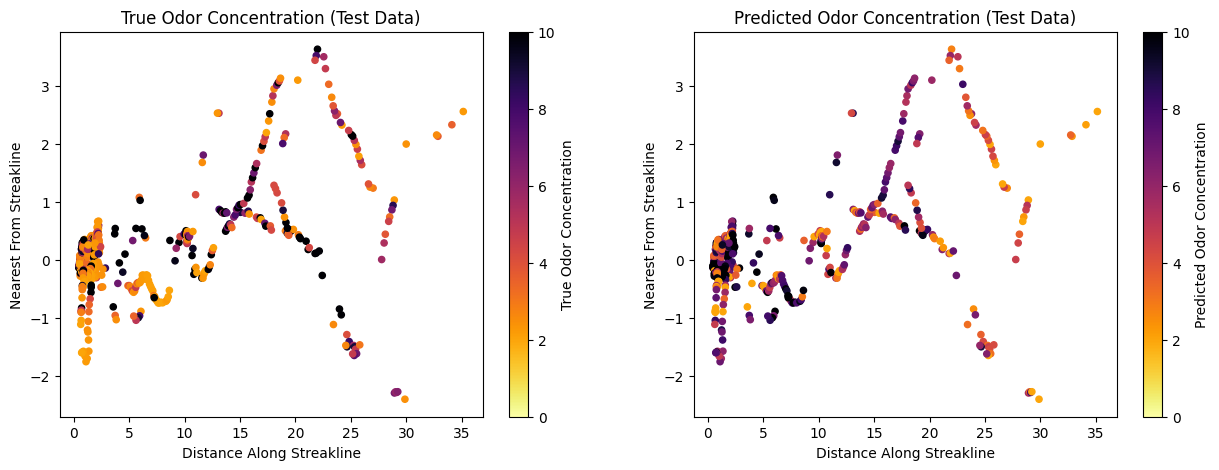

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['whiff_probability'], cmap='inferno_r', s=20)
plt.colorbar(label='Whiff Initiation Probability')
plt.title('Whiff Initiation Probability (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 2)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['predicted_whiff_duration'], cmap='inferno_r', s=20)
plt.colorbar(label='Predicted Whiff Duration')
plt.title('Predicted Whiff Duration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')

plt.subplot(1, 3, 3)
plt.scatter(new_test_df['distance_along_streakline'], new_test_df['nearest_from_streakline'], c=new_test_df['final_predicted_concentration'], cmap='inferno_r', s=20)
plt.colorbar(label='Final Predicted Odor Concentration')
plt.title('Final Predicted Odor Concentration (Test Data)')
plt.xlabel('Distance Along Streakline')
plt.ylabel('Nearest From Streakline')


(array([0.1720113 , 0.10902125, 0.07752622, 0.11144394, 0.10175316,
        0.09933047, 0.11386663, 0.10175316, 0.07268083, 0.24711482]),
 array([ 2.00024006,  2.8290826 ,  3.65792515,  4.48676769,  5.31561023,
         6.14445277,  6.97329531,  7.80213785,  8.63098039,  9.45982293,
        10.28866548]),
 [<matplotlib.patches.Polygon at 0x7a1099673a90>])

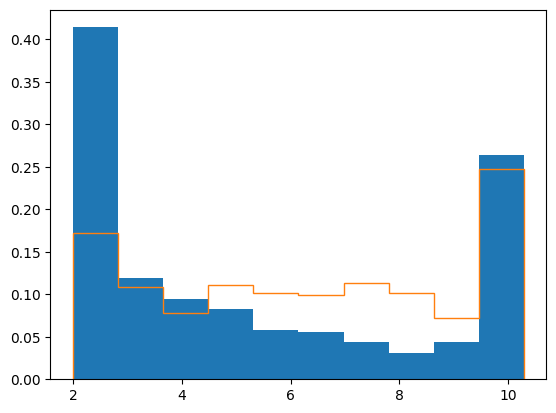

In [32]:
plt.hist(new_test_df.odor, density=True)
plt.hist(new_test_df.adjusted_y_predicted_clipped, histtype='step', density=True)

In [92]:
def cal_stat(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff(df,idx,df2)
    osc.mean_avg(df,idx,df2)
    osc.encounter_frequency(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)

def cal_stat_predicted(df,idx,df2):
    osc.avg_distance(df,idx,df2)
    osc.predicted_mean_conc(df,idx,df2)
    osc.whiff_blank_duration(df,idx,df2)
    osc.std_whiff_predicted(df,idx,df2)
    osc.mean_avg_predicted(df,idx,df2)
    osc.encounter_frequency_predicted(df,idx,df2,1,2)
    osc.mean_t(df,idx,df2)
th = 4
np.seterr(divide='ignore')
index = osc.get_index(new_test_df.odor,th)
index_predicted = osc.get_index(new_test_df.predicted_odor,th)
fdf = pd.DataFrame()
fdf_predicted = pd.DataFrame()

cal_stat(new_test_df,index,fdf)
cal_stat_predicted(new_test_df,index_predicted, fdf_predicted)

fdf.keys()

/home/gorilla/An/plume_sim/odor_stat_calculations.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.efreq.iloc[start] = 1
/home/gorilla/An/plume_sim/odor_stat_calculations.py:211: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.efreq.iloc[start] = 1


Index(['avg_dist_from_source', 'log_avg_dist_from_source',
       'mean_concentration', 'length_of_encounter', 'odor_intermittency',
       'log_whiff', 'log_blank', 'std_whiff', 'whiff_ma', 'wf', 'mean_time'],
      dtype='object')

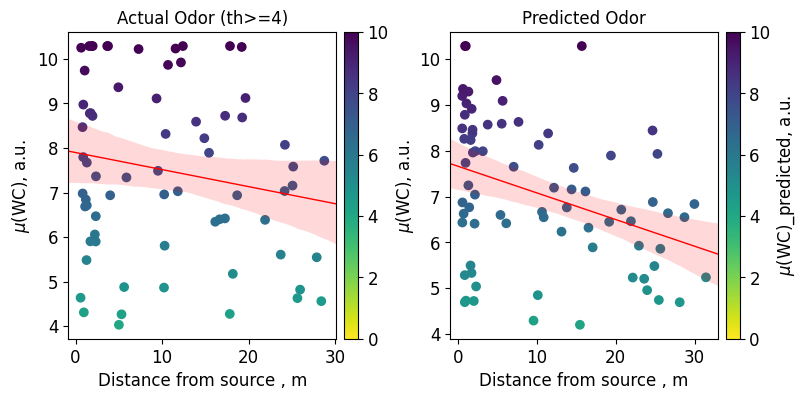

In [93]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var1 = ax1.scatter(fdf.avg_dist_from_source,fdf.mean_concentration, c=fdf.mean_concentration, cmap='viridis_r', vmin=0,vmax=10 )
ax1.set_ylabel('$\mu$(WC), a.u.')


g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.mean_concentration , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var1, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
ax1.set_ylabel('$\mu$(WC), a.u.')
ax1.set_title('Actual Odor (th>='+str(th)+')')

var2=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.mean_concentration, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10 )
# ax2.set_ylabel('Whiff Concentration, a.u.')


g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.mean_concentration , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

ax2.set_xlabel('Distance from source , m')
# ax2.set_ylabel('$\mu$(WC), a.u.')
ax2.set_title('Predicted Odor')
f.tight_layout(pad=1)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

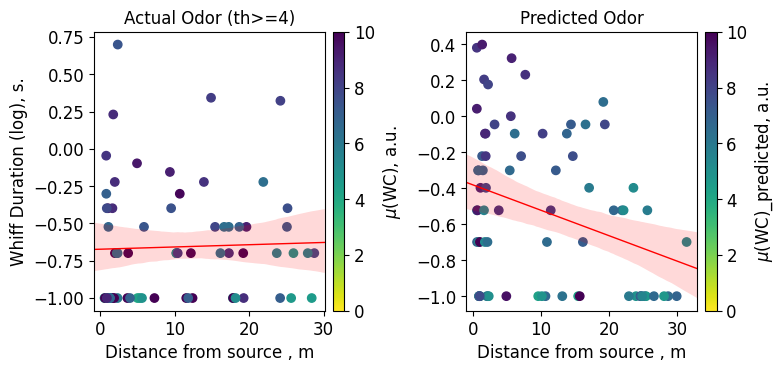

In [96]:
### WHIFF DURATION
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.log_whiff, c=fdf.mean_concentration, cmap='viridis_r',vmin=0,vmax=10  )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.log_whiff , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(WC), a.u.')

ax1.set_xlabel('Distance from source , m')
# ax1.set_title('Odor>0.5 =Whiff')
ax1.set_ylabel('Whiff Duration (log), s.')
ax1.set_title('Actual Odor (th>='+str(th)+')')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.log_whiff, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r',vmin=0,vmax=10)

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.log_whiff , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)

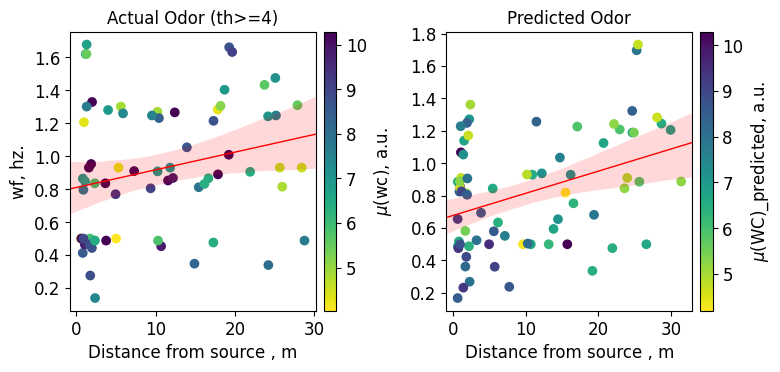

In [97]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,4))
var = ax1.scatter(fdf.avg_dist_from_source,fdf.wf, c=fdf.mean_concentration, cmap='viridis_r' )
ax1.set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=fdf.avg_dist_from_source,y=fdf.wf , data=fdf,
            ax=ax1, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.08)
cbar=f.colorbar(var, cax=cax, orientation = 'vertical')
cbar.solids.set(alpha=1)
cbar.set_label('$\mu$(wc), a.u.')

ax1.set_xlabel('Distance from source , m')
# ax1.set_title('Odor>0.5 =Whiff')
ax1.set_title('Actual Odor (th>='+str(th)+')')
ax1.set_ylabel('wf, hz.')


u=ax2.scatter(fdf_predicted.avg_dist_from_source,
              fdf_predicted.wf, 
              c=fdf_predicted.mean_concentration, cmap='viridis_r' )

g2 = sns.regplot(x=fdf_predicted.avg_dist_from_source,y=fdf_predicted.wf , data=fdf_predicted,
            ax=ax2, line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax2)
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(u, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

# ax2.set_ylabel('Whiff Duration, s')
ax2.set_xlabel('Distance from source , m')
ax2.set_title('Predicted Odor')

f.tight_layout(pad=2)

mpl_functions.set_fontsize(f, 12)
# f.savefig('../assets/300_ensemble_full.jpeg', dpi=150, bbox_inches = "tight")

In [99]:
def create_class_column(dataframe):
    dataframe.loc[dataframe.avg_dist_from_source < 10, 'type'] = 0
    dataframe.loc[(dataframe.avg_dist_from_source >= 10)  & (dataframe.avg_dist_from_source < 20), 'type'] = 1
    dataframe.loc[dataframe.avg_dist_from_source >= 20, 'type'] = 2
    return dataframe

fdf_new = create_class_column(fdf)
fdf_predicted_new = create_class_column(fdf_predicted)

In [100]:
lookback_time = 5

trainset= fdf_new

D_train=[]
mean_time_train=[]
Xtrain = []
ytrain = []
Nrows_train = []

for distance_class in [0,1,2]:
    Xtrain, ytrain, D_train, Nrows_train,mean_time_train = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain, ytrain, D_train, Nrows_train,
                      mean_time_train)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf.loc[i]=np.ravel(X)
        
traindf['distance']=np.delete(D_train, c1)
traindf['mean_whiff_time'] = np.delete(mean_time_train, c1)
traindf['nwhiffs'] = np.delete(Nrows_train, c1)

/tmp/ipykernel_843190/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2321856514.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occu

In [101]:
lookback_time = 5

trainset_predicted= fdf_predicted_new
# trainset= fdf_predicted_new

D_train_predicted=[]
mean_time_train_predicted=[]
Xtrain_predicted = []
ytrain_predicted = []
predictions_filled = []
mean_time_train_predicted = []
Nrows_train_predicted = []

for distance_class in [0,1,2]:
    Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted , mean_time_train_predicted = osc.gather_stat_timed(trainset, distance_class,
                      lookback_time, Xtrain_predicted, ytrain_predicted, D_train_predicted, Nrows_train_predicted,
                      mean_time_train_predicted)
    
def calc_val(X):
    return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])

column_names=['mc_min','mc_max','mc_mean','mc_std_dev','mc_k',
             'wf_min','wf_max','wf_mean','wf_std_dev','wf_k',
             'wd_min','wd_max','wd_mean','wd_std_dev','wd_k',
             'ma_min','ma_max','ma_mean','ma_std_dev','ma_k',
             'st_min','st_max','st_mean','st_std_dev','st_k']

traindf_predicted=pd.DataFrame(columns = column_names)
c1=[]
for i in range(len(Xtrain)):
    if(np.size(Xtrain[i])==0):
        c1.append(i)
        continue
    else:
        X=[]
        for j in range(len(Xtrain[i])):
            X.append(calc_val(Xtrain[i][j]))
        traindf_predicted.loc[i]=np.ravel(X)
        
traindf_predicted['distance']=np.delete(D_train_predicted, c1)
traindf_predicted['mean_whiff_time'] = np.delete(mean_time_train_predicted, c1)

/tmp/ipykernel_843190/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  return np.ravel([np.min(X),np.max(X),np.mean(X),np.std(X),kurtosis(X)])
/tmp/ipykernel_843190/2500237992.py:20: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occu

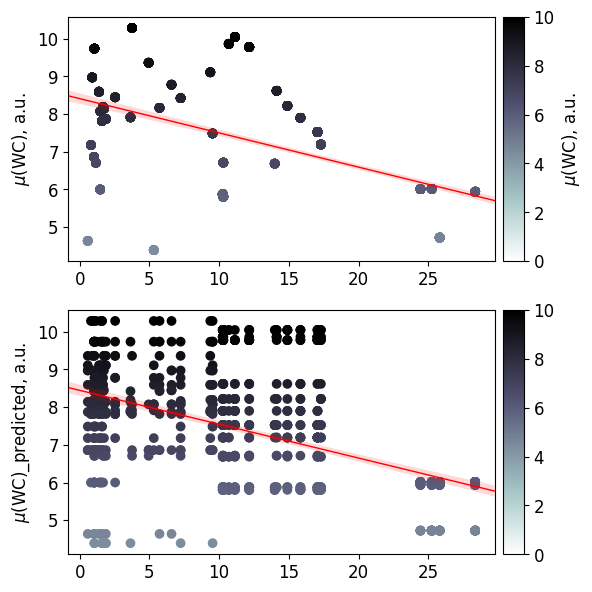

In [105]:
f,ax = plt.subplots(2,1,figsize=(6,6))
var1 =ax[0].scatter(traindf.distance, traindf.mc_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)


divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), a.u.')
ax[0].set_ylabel('$\mu$(WC), a.u.')

g1 = sns.regplot(x=traindf.distance,y=traindf.mc_mean, data=traindf,
            ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.mc_mean, c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.mc_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
ax[0].set_ylabel('$\mu$(WC), a.u.')
ax[1].set_ylabel('$\mu$(WC)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


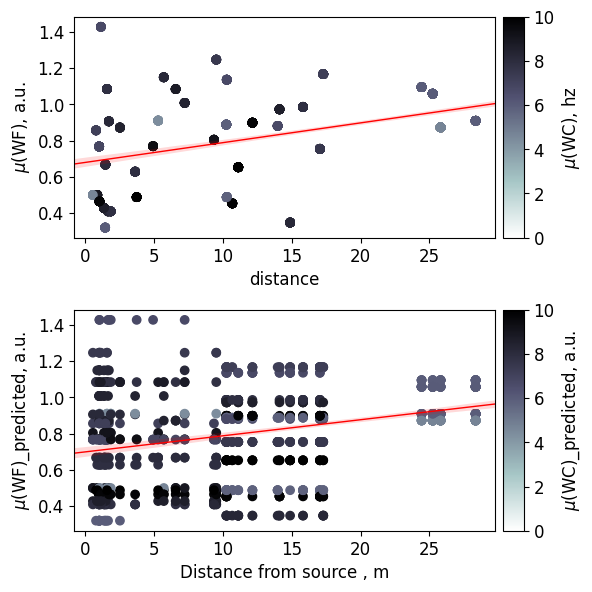

In [117]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wf_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.wf_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wf_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.wf_mean, data=traindf_predicted,
            ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')

predictions_filled
ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WF), a.u.')
ax[1].set_ylabel('$\mu$(WF)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)


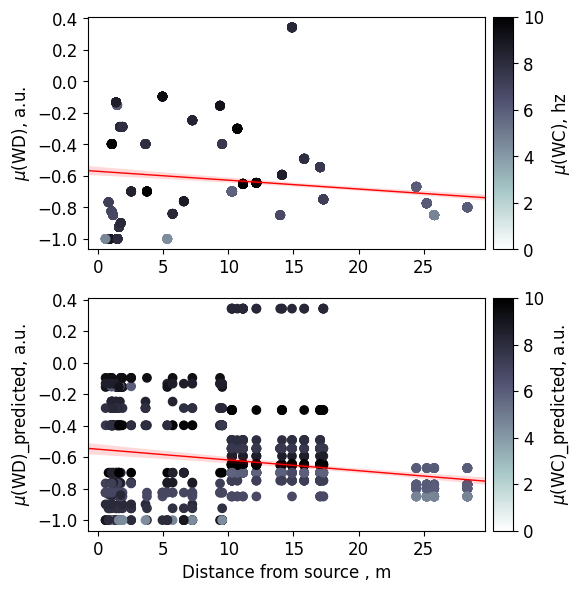

In [115]:
f,ax = plt.subplots(2,1,figsize=(6,6))


var1 =ax[0].scatter(traindf.distance, traindf.wd_mean, c=traindf.mc_mean, cmap='bone_r', vmin=0, vmax=10)

divider = make_axes_locatable(ax[0])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var1, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC), hz')

g1 = sns.regplot(x=traindf.distance,y=traindf.wd_mean, data=traindf, ax=ax[0], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g1.set(xlabel=None, ylabel=None)

var2 =ax[1].scatter(traindf_predicted.distance, traindf_predicted.wd_mean,c=traindf_predicted.mc_mean, cmap='bone_r', vmin=0, vmax=10,)

g2 = sns.regplot(x=traindf_predicted.distance,y=traindf_predicted.wd_mean, data=traindf_predicted, ax=ax[1], line_kws={'color':'red','linewidth':1}, scatter=False, truncate=False)
g2.set(xlabel=None, ylabel=None)

divider = make_axes_locatable(ax[1])
cax1 = divider.append_axes('right', size='5%', pad=0.08)
cbar1=f.colorbar(var2, cax=cax1, orientation = 'vertical')
cbar1.solids.set(alpha=1)
cbar1.set_label('$\mu$(WC)_predicted, a.u.')


ax[1].set_xlabel('Distance from source , m')
ax[0].set_ylabel('$\mu$(WD), a.u.')
ax[1].set_ylabel('$\mu$(WD)_predicted, a.u.')

mpl_functions.set_fontsize(f, 12)
f.tight_layout(pad=1)
